# Libraries

In [1]:
# Libraries
import sys
import os
import numpy as np
import time
from tqdm import tqdm

#Plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl

#Machine Learning Libraries
import jax
from jax import jit, grad, vmap, value_and_grad
from jax.config import config
import jax.numpy as jnp
import optax
import jaxopt
from typing import List, Dict, Tuple
from pyDOE import lhs


# Auxiliary Functions

In [2]:
def Encode_Fourier(X,M,N):
    x=X[0]
    y=X[1]
    P_x=2
    P_y=2
    n_num = jnp.arange(1, N+1)
    m_num = jnp.arange(1, M+1)
    n, m = jnp.meshgrid(n_num, m_num)
    n=n.flatten()
    m=m.flatten()
    w_x = 2.0 * jnp.pi / P_x
    w_y = 2.0 * jnp.pi / P_y    
    out = jnp.hstack([jnp.cos(n* w_x * x)  * jnp.cos(m * w_y * y),
                      jnp.cos(n * w_x * x) * jnp.sin(m * w_y * y),
                      jnp.sin(n * w_x * x) * jnp.cos(m * w_y * y),])
    return out
def identity(X,X_min,X_max):
    return X
def MSE(pred,exact,weight=1):
    return jnp.mean(weight*jnp.square(pred - exact))
def relative_error2(pred,exact):
    return np.linalg.norm(exact-pred,2)/np.linalg.norm(exact,2)
#Initialization
def glorot_normal(in_dim, out_dim):
    glorot_stddev = np.sqrt(2.0 / (in_dim + out_dim))
    W = glorot_stddev * jnp.array(np.random.normal(size=(in_dim, out_dim)))
    return W
def init_params(layers, Mod_MLP=True):
    params = []
    in_dim, out_dim = layers[0], layers[1]
    U1=glorot_normal(in_dim, out_dim)
    b1=jnp.zeros(out_dim)
    U2=glorot_normal(in_dim, out_dim)
    b2=jnp.zeros(out_dim)
    for i in range(len(layers) - 1):
        in_dim, out_dim = layers[i], layers[i + 1]
        W = glorot_normal(in_dim, out_dim)
        b = jnp.zeros(out_dim)
        if i ==0:
            params.append({"W": W, "b": b, "U1":U1, "b1":b1,"U2":U2, "b2":b2,})
        else:
            params.append({"W": W, "b": b})
    return params

def FCN_MMLP(params,X_in,M1,M2,activation,norm_fn):#Modified MLP
    inputs =norm_fn(X_in,M1,M2)
    # MMLP
    U1=params[0]["U1"]
    U2=params[0]["U2"]
    b1=params[0]["b1"]
    b2=params[0]["b2"]
    U =activation(jnp.dot(inputs, U1) + b1)
    V =activation(jnp.dot(inputs, U2) + b2)
    for layer in params[:-1]:
        outputs = activation(inputs @ layer["W"] + layer["b"]) 
        inputs  = jnp.multiply(outputs, U) + jnp.multiply(1 - outputs, V) 
    W = params[-1]["W"]
    b = params[-1]["b"]
    outputs = jnp.dot(inputs, W) + b
    return outputs
def plot3D_mat(x,y,F,f_names,window=4,font_size='10',x_label='x',y_label='y',cmap='rainbow',fig_width=6):
  X,Y= x,y
  fig,ax=plt.subplots(1,len(F),figsize=(fig_width*len(F),window))
  plt.rcParams['font.size'] = font_size
  for i in range(len(ax)):
    cp = ax[i].contourf(X,Y, F[i],50,cmap=cmap)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax[i].set_title(f_names[i])
    ax[i].set_xlabel(x_label)
    if i==0:
        ax[i].set_ylabel(y_label)

# Tunning Parameters

In [3]:
Mode='ADF'
use_RBA=True
Mod_MLP=True
seed_np=5555

#Model
num_layer=6
width_layer = 128 # neurons/layer
layers = [2] + num_layer*[width_layer] + [1]
print('Model Architecture:')
print(layers)
#Optimization
num_epochs_adam =20*(10**3)
num_epochs_lbfgsb =1*(10**3)
substepts_lbfgs=5
#Global weights
lamB =100
lamE =1
#learning 
lr0=5*10**(-3)
lrf=1*10**(-5)
#RBA
lr_lambdas_0=1*10**(-2)
decay_rate=0.7
decay_step=1000
gamma=0.999
lam_min=0.0
init_zero=True
#Number of training points
N0 = 50
N_b = 50
nxb, nyb = (101,101)
N_f = nxb*nyb
#Fourier 
N=5
M=5
#Helmhotz Details
a1 = 1.0
a2 = 4.0
ksq = 1.0

Model Architecture:
[2, 128, 128, 128, 128, 128, 128, 1]


In [4]:
# Settings
if Mode.lower()  == 'fourier':
    dim_in = N * M * 3
    layers = [dim_in] + num_layer*[width_layer] + [1]
    print('New Model Architecture:')
    print(layers)
    print('Mode:')
    print(Mode)
activation_fn=jnp.tanh
if Mode.lower()=='adf':
    norm_fn    = identity
    Norm_metric1=lambda x: 0
    Norm_metric2=lambda x: 0  
elif Mode.lower()=='fourier':
    norm_fn    = Encode_Fourier
    Norm_metric1=lambda x: N
    Norm_metric2=lambda x: M  
# Errors
Error_fn=MSE
# Initialize NN
np.random.seed(seed_np)
params = init_params(layers) 
pinn_fn = FCN_MMLP
#Optimizer
optimizer_w = optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate,))
opt_state_w = optimizer_w.init(params)
M1= Norm_metric1(1)
M2= Norm_metric2(1)
    

## Generate Data


In [5]:
lb = np.array([-1.0])
ub = np.array([1.0])
rb = np.array([1.0])
lftb = np.array([-1.0])
nx, ny = (1001,1001)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
xv, yv = np.meshgrid(x,y)
x = np.reshape(x, (-1,1))
y = np.reshape(y, (-1,1))


In [6]:
# Exact solution to compute errors and evaluate performance
Exact_u = np.sin(a1*np.pi*xv)*np.sin(a2*np.pi*yv)
X,Y=np.meshgrid(x,y,indexing='ij')
u=np.reshape(Exact_u ,(nx,ny)).T
Exact=np.array([u,u]) #we store them this way only to plot them
X_exact=np.hstack((X.flatten()[:,None],
                   Y.flatten()[:,None],
                   u.flatten()[:,None]))

# Training Points

In [7]:
xb = np.linspace(-1, 1, N_b)
yb = np.linspace(-1, 1, N_b)
Xb, Yb = np.meshgrid(xb,yb)
xb = np.reshape(xb, (-1,1))
yb = np.reshape(yb, (-1,1))
X_lb = np.hstack((Xb[0,:].flatten()[:,None],Yb[0,:].flatten()[:,None]))
X_ub = np.hstack((Xb[-1,:].flatten()[:,None],Yb[-1,:].flatten()[:,None]))
X_rb = np.hstack((Xb[:,0].flatten()[:,None],Yb[:,0].flatten()[:,None]))
X_lftb = np.hstack((Xb[:,-1].flatten()[:,None],Yb[:,-1].flatten()[:,None]))

# Collocation Points

In [8]:
xb = np.linspace(-1, 1, nxb)
yb = np.linspace(-1, 1, nyb)
Xb, Yb = np.meshgrid(xb,yb)
xb = np.reshape(xb, (-1,1))
yb = np.reshape(yb, (-1,1))
X_f=np.hstack((Xb.flatten()[:,None],Yb.flatten()[:,None]))


# Define data details

In [9]:
X_res    =X_f
X_BCs_U  =X_ub
X_BCs_L  =X_lb
X_BCs_R  =X_rb
X_BCs_Lf  =X_lftb

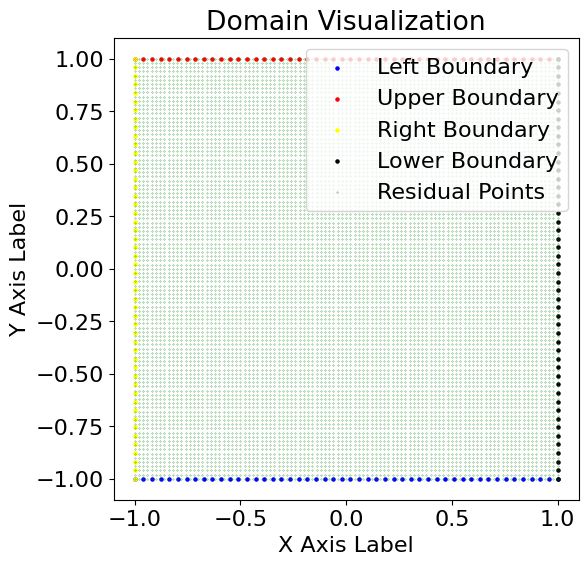

In [10]:
figsize = (6,6)
fig = plt.figure(figsize=figsize)
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1, 1, 1)

# Scatter plots for each boundary condition or region with labels for the legend
ax.scatter(X_BCs_L[:,0], X_BCs_L[:,1], c='b', s=5, label='Left Boundary')
ax.scatter(X_BCs_U[:,0], X_BCs_U[:,1], c='r', s=5, label='Upper Boundary')
ax.scatter(X_BCs_R[:,0], X_BCs_R[:,1], c='yellow', s=5, label='Right Boundary')
ax.scatter(X_BCs_Lf[:,0], X_BCs_Lf[:,1], c='k', s=5, label='Lower Boundary')
ax.scatter(X_res[:,0], X_res[:,1], c='g', s=0.05, label='Residual Points')

# Adding a legend to the plot to differentiate the scatter points
plt.legend()

# Adding a title and axis labels
plt.title('Domain Visualization')
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')

# Displaying the plot
plt.show()


# Initilize RBA Weights

In [11]:
np.random.seed(seed_np)
lambda_bcs=np.random.uniform(0,1,X_BCs_U.shape[0]*layers[-1]).reshape(X_BCs_U.shape[0],layers[-1])
lambda_res=np.random.uniform(0,1,X_res.shape[0]*layers[-1]).reshape(X_res.shape[0],layers[-1])
if init_zero:
    print('Setting Zero Initialization')
    lambda_bcs=lambda_bcs
    lambda_res=lambda_res*0
lambdas={
         'BCs':lambda_bcs,
         'Res':lambda_res}

Setting Zero Initialization


# Loss Functions

In [12]:
def u_PINN(params):
    u_NN = lambda x: pinn_fn(params, x,M1,M2,activation_fn,norm_fn)
    u = lambda x: u_NN(x)[0]
    return u    
def u_adf(params):
    u_NN = lambda x: pinn_fn(params, x,M1,M2,activation_fn,norm_fn)
    u    = lambda x: (x[0]**2-1)*(x[1]**2-1)*u_NN(x)[0]   
    return u   
if Mode.lower()=='adf':
    u_model=u_adf
    lamB=0
    #Def PDE
    def PDE(params):
        u_NN = lambda x: pinn_fn(params, x,M1,M2,activation_fn,norm_fn)
        u    = lambda x: (x[0]**2-1)*(x[1]**2-1)*u_NN(x)[0]  
        # derivatives
        u_x              = lambda x: grad(u)(x)[0]
        u_y              = lambda x: grad(u)(x)[1]
        u_xx             = lambda x: grad(u_x)(x)[0]
        u_yy             = lambda x: grad(u_y)(x)[1]
        #Forcing Term
        q                = lambda x:(- (a1*jnp.pi)**2*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]) - 
                                    (a2*jnp.pi)**2*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]) + 
                                        ksq*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]))
        # equations
        eq1 = (
                        lambda x:  u_xx(x) + u_yy(x) + ksq*u(x) - q(x)
        )
        
        return eq1
else:
    u_model=u_PINN
    #Def PDE
    def PDE(params):
        u_NN = lambda x: pinn_fn(params, x,M1,M2,activation_fn,norm_fn)
        u = lambda x: u_NN(x)[0]
        # derivatives
        u_x              = lambda x: grad(u)(x)[0]
        u_y              = lambda x: grad(u)(x)[1]
        u_xx             = lambda x: grad(u_x)(x)[0]
        u_yy             = lambda x: grad(u_y)(x)[1]
        #Forcing Term
        q                = lambda x:(- (a1*jnp.pi)**2*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]) - 
                                    (a2*jnp.pi)**2*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]) + 
                                        ksq*jnp.sin(a1*jnp.pi*x[0])*jnp.sin(a2*jnp.pi*x[1]))
        # equations
        eq1 = (
                        lambda x:  u_xx(x) + u_yy(x) + ksq*u(x) - q(x)
        )
        
        return eq1
print('Choosen Model:',u_model)
print(f'Weights for BCs and eq:{lamB},{lamE}')

Choosen Model: <function u_adf at 0x7f5d55766310>
Weights for BCs and eq:0,1


In [13]:
# For Adam Optimizer
@jit
def update(params, 
           lambdas,
           opt_state_w, 
           data: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray],
           idx_res,
           epoch):
    X_BCs_U, X_BCs_L,X_BCs_R,X_BCs_Lf, X_res  = data
    X_res_subset=X_res[idx_res]
    eq1                 = PDE(params)
    #compute Errors
    e_helmholtz         = vmap(eq1, (0))(X_res_subset)[:,None]
    r_j=jnp.abs(e_helmholtz)
    #Update lambdas
    lam_res             = (gamma)*lambdas['Res'][idx_res] + lr_lambdas_0*(r_j/jnp.max(r_j))
    lambdas['Res']      = lambdas['Res'].at[idx_res].set(lam_res)
    def loss_fn(params):
        X_res_subset=X_res[idx_res]
        # Call Functions
        eq1                 = PDE(params)
        u_fx                = u_model(params)
        # Residuals prediction
        e_helmholtz         = vmap(eq1, (0))(X_res_subset)[:,None]
        # BCs prediction 
        tx_up          = X_BCs_U[:, :2]
        u_pred_bcs_up  = vmap(u_fx, (0))(tx_up)[:,None]
        # BCs prediction 
        tx_low        = X_BCs_L[:, :2]
        u_pred_bcs_low= vmap(u_fx, (0))(tx_low)[:,None]
        # BCs prediction 
        tx_r        = X_BCs_R[:, :2]
        u_pred_bcs_r= vmap(u_fx, (0))(tx_r)[:,None]
        # BCs prediction 
        tx_lft        = X_BCs_Lf[:, :2]
        u_pred_bcs_lft= vmap(u_fx, (0))(tx_lft)[:,None]
        #Add 
        # Loss Weights
        lamE_it=use_RBA*lambdas['Res'][idx_res]+(1-use_RBA)+lam_min    
        lamB_it=1
        #Loss Equation
        loss_helmholtz           = lamE*Error_fn(e_helmholtz,0.0,weight=lamE_it)
        #Total Loss
        loss                = (        
                              + loss_helmholtz
                              )
        return loss, (
                     (loss,
                      Error_fn(e_helmholtz,0.0)),
                     lambdas
        )

    grad_fn = value_and_grad(loss_fn, has_aux=True)
    #Update weights
    (_, aux_vals),all_grads=grad_fn(params)
    losses,lambdas         =aux_vals
    grad_w                 =all_grads
    updates, opt_state_w = optimizer_w.update(grad_w, opt_state_w, params)
    params  = optax.apply_updates(params, updates)
    return params, lambdas, opt_state_w, losses, grad_w

In [14]:

def get_errors(epoch,Errors,N_its,params,X_exact):
    N_its=int(N_its/100)
    errors=np.zeros((1,3))
    eq1                 = PDE(params)
    u_fx                = u_model(params)
    # Residuals prediction
    e_helmholtz   = vmap(eq1, (0))(X_res)[:,None]
    # Prediction 
    xy, u_real          = X_exact[:, :2], X_exact[:, 2:]
    u_pred              = vmap(u_fx, (0))(xy)[:,None]
    u_pred              =jax.device_get(u_pred)
    #Compute errors
    errors[0,0]=relative_error2(u_pred,u_real)
    errors[0,1]=np.linalg.norm(u_real-u_pred,np.inf)
    errors[0,2]=Error_fn(e_helmholtz,0.0)
    Errors=np.vstack((Errors,errors))
    n_errors=np.arange(len(Errors)-1)*100
    return u_pred,e_helmholtz,errors,Errors

# ADAM Training 


In [15]:
log_loss     = []
log_epoch    = []
log_lambdas  = []
epoch_losses = []
log_u_pred   = []
log_res      = []
starting_epoch=0
M1= Norm_metric1(X_res[:, :2])
M2= Norm_metric2(X_res[:, :2])
Errors=np.zeros((1,3))
errors=np.zeros((1,3))
start_time = time.time()
start_time2 = time.time()
for epoch in range(1, num_epochs_adam+1):
    #idx_res=np.random.choice(len(X_res),int(len(X_res)*1)) 
    idx_res=np.arange(len(X_res))
    batch_data =   (X_BCs_U,
                    X_BCs_L,
                    X_BCs_R,
                    X_BCs_Lf,
                    X_res)
    params, lambdas, opt_state_w, batch_losses, grad_w = update(
    params, lambdas, opt_state_w, batch_data,idx_res,epoch)

    if epoch==1 or (epoch%50)==0:
        end_time = time.time()
        #Get Losses
        epoch_losses.append(batch_losses)
        loss_avg: np.ndarray = np.mean(np.array(jax.device_get(epoch_losses)), axis=0)
        (
                loss,
                loss_helmholtz,
        ) = loss_avg
        log_lambdas.append(jax.device_get(lambdas))     
        # Learnig Rate
        optim_step =  epoch
        lr = lr0 * decay_rate ** (optim_step / decay_step)
        ##Store
        log_epoch.append(epoch)
        log_loss.append(loss_avg)
        #Get Errors
        u_pred,e_helmholtz,errors,Errors=get_errors(epoch,Errors,num_epochs_adam,params,
                                                    X_exact)
        log_u_pred.append(u_pred)
        log_res.append(e_helmholtz)
        Error    =(
                +loss_helmholtz)
        lambda_bcs_print=np.mean(lamB*lambdas['BCs'])
        lambda_res_print=np.mean(lamE*lambdas['Res'])

        print("-" * 50)
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Time: {end_time-start_time:.2f}s, Learning Rate: {lr:.1e}")
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Total Error: {Error:.3e}, Total Loss: {loss:.3e}")
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Relative L2: {errors[0,0]:.3e}, L Linfty: {errors[0,1]:.3e}")
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Loss_helmholtz: {loss_helmholtz:.3e}")
        print(
        f"Epoch: {epoch:d}, It: {optim_step:d}, Lambda BCs: {lambda_bcs_print:.3e}, Lambda PDE: {lambda_res_print:.3e}")

        start_time = time.time()

end_time2 = time.time()

--------------------------------------------------
Epoch: 1, It: 1, Time: 15.15s, Learning Rate: 5.0e-03
Epoch: 1, It: 1, Total Error: 6.817e+03, Total Loss: 4.887e+01
Epoch: 1, It: 1, Relative L2: 1.002e+00, L Linfty: 1.098e+00
Epoch: 1, It: 1, Loss_helmholtz: 6.817e+03
Epoch: 1, It: 1, Lambda BCs: 0.000e+00, Lambda PDE: 3.950e-03
--------------------------------------------------
Epoch: 50, It: 50, Time: 0.79s, Learning Rate: 4.9e-03
Epoch: 50, It: 50, Total Error: 4.688e+03, Total Loss: 3.236e+02
Epoch: 50, It: 50, Relative L2: 1.724e+00, L Linfty: 2.953e+00
Epoch: 50, It: 50, Loss_helmholtz: 4.688e+03
Epoch: 50, It: 50, Lambda BCs: 0.000e+00, Lambda PDE: 1.536e-01
--------------------------------------------------
Epoch: 100, It: 100, Time: 0.80s, Learning Rate: 4.8e-03
Epoch: 100, It: 100, Total Error: 3.133e+03, Total Loss: 2.177e+02
Epoch: 100, It: 100, Relative L2: 1.543e-01, L Linfty: 2.184e-01
Epoch: 100, It: 100, Loss_helmholtz: 3.133e+03
Epoch: 100, It: 100, Lambda BCs: 0.0

# LBFGs Training 

In [16]:
# For L-BFGS-B
def get_losses(params,X_res):
    lamE_it=use_RBA*lambdas['Res']+(1-use_RBA)
    lamB_it=1
    # Call Functions
    eq1                 = PDE(params)
    u_fx                = u_model(params)
    # Residuals prediction
    e_helmholtz         = vmap(eq1, (0))(X_res)[:,None]

    # BCs prediction 
    tx_up          = X_BCs_U[:, :2]
    u_pred_bcs_up  = vmap(u_fx, (0))(tx_up)[:,None]
    # BCs prediction 
    tx_low        = X_BCs_L[:, :2]
    u_pred_bcs_low= vmap(u_fx, (0))(tx_low)[:,None]

    # BCs prediction 
    tx_r        = X_BCs_R[:, :2]
    u_pred_bcs_r= vmap(u_fx, (0))(tx_r)[:,None]

    # BCs prediction 
    tx_lft        = X_BCs_Lf[:, :2]
    u_pred_bcs_lft= vmap(u_fx, (0))(tx_lft)[:,None]
    
    #Loss Equation
    loss_helmholtz           = lamE*Error_fn(e_helmholtz,0.0,weight=lamE_it)
    #Loss Bcs u
    loss_up                  = lamB*Error_fn(u_pred_bcs_up,0.0,weight=lamB_it)
    loss_low                 = lamB*Error_fn(u_pred_bcs_low,0.0,weight=lamB_it)
    loss_r                   = lamB*Error_fn(u_pred_bcs_r,0.0,weight=lamB_it)
    loss_lf                  = lamB*Error_fn(u_pred_bcs_lft,0.0,weight=lamB_it)
    #Total Loss
    loss                = (        
                            + loss_helmholtz
                            + loss_up
                            + loss_low
                            + loss_r
                            + loss_lf
                            )
    all_losses=[
        loss,
        Error_fn(e_helmholtz,0.0),
        jnp.mean(jnp.square(u_pred_bcs_up)
                    +jnp.square(u_pred_bcs_low)
                    +jnp.square(u_pred_bcs_up)
                    +jnp.square(u_pred_bcs_up)),]
    return all_losses

def loss_fn(params):
    lamE_it=use_RBA*lambdas['Res']+(1-use_RBA)
    lamB_it=1
    # Call Functions
    eq1                 = PDE(params)
    u_fx                = u_model(params)
    # Residuals prediction
    e_helmholtz         = vmap(eq1, (0))(X_res)[:,None]

    # BCs prediction 
    tx_up          = X_BCs_U[:, :2]
    u_pred_bcs_up  = vmap(u_fx, (0))(tx_up)[:,None]
    # BCs prediction 
    tx_low        = X_BCs_L[:, :2]
    u_pred_bcs_low= vmap(u_fx, (0))(tx_low)[:,None]

    # BCs prediction 
    tx_r        = X_BCs_R[:, :2]
    u_pred_bcs_r= vmap(u_fx, (0))(tx_r)[:,None]

    # BCs prediction 
    tx_lft        = X_BCs_Lf[:, :2]
    u_pred_bcs_lft= vmap(u_fx, (0))(tx_lft)[:,None]
    
    #Loss Equation
    loss_helmholtz           = lamE*Error_fn(e_helmholtz,0.0,weight=lamE_it)
    #Loss Bcs u
    loss_up                  = lamB*Error_fn(u_pred_bcs_up,0.0,weight=lamB_it)
    loss_low                 = lamB*Error_fn(u_pred_bcs_low,0.0,weight=lamB_it)
    loss_r                   = lamB*Error_fn(u_pred_bcs_r,0.0,weight=lamB_it)
    loss_lf                  = lamB*Error_fn(u_pred_bcs_lft,0.0,weight=lamB_it)
    #Total Loss
    loss                = (        
                            + loss_helmholtz
                            + loss_up
                            + loss_low
                            + loss_r
                            + loss_lf
                            )
    return loss
            
def Callback_Loss(params_i):
    global log_loss,log_lambdas
    global log_epoch
    global epoch
    global start_time
    global Errors
    global Mu
    global Sigmas
    global lambdas,gamma,lr_lambdas_0
    if  epoch%1==0:
        if  epoch%100==0:
            end_time = time.time()
            all_losses=get_losses(params_i,X_res)
            loss           =all_losses[0]
            loss_helmholtz =all_losses[1]
            loss_u_bcs     =all_losses[2]
            # Learnig Rate
            optim_step =  epoch
            ##Store
            log_epoch.append(epoch)
            #Plot Lambdas
            u_pred,e_helmholtz,errors,Errors=get_errors(epoch,Errors,
                                                        num_epochs_adam+num_epochs_lbfgsb,
                                                        params_i,
                                                        X_exact,)
            log_lambdas.append(lambdas)
            log_u_pred.append(u_pred)
            log_res.append(e_helmholtz)
            Error    =(
                    +loss_helmholtz
                    +loss_u_bcs)
            lambda_bcs_print=np.mean(lamB*lambdas['BCs'])
            lambda_res_print=np.mean(lamE*lambdas['Res'])
            print("-" * 50)
            print(
            f"Epoch: {epoch:d}, It: {optim_step:d}, Time: {end_time-start_time:.2f}s, Learning Rate: {lr:.1e}")
            print(
            f"Epoch: {epoch:d}, It: {optim_step:d}, Total Error: {Error:.3e}, Total Loss: {loss:.3e}")
            print(
            f"Epoch: {epoch:d}, It: {optim_step:d}, Relative L2: {errors[0,0]:.3e}, Relative Linfty: {errors[0,1]:.3e}")
            print(
            f"Epoch: {epoch:d}, It: {optim_step:d}, Loss_helmholtz: {loss_helmholtz:.3e}, Loss BCs(u): {loss_u_bcs:.3e}")
            print(
            f"Epoch: {epoch:d}, It: {optim_step:d}, Lambda BCs: {lambda_bcs_print:.3e}, Lambda PDE: {lambda_res_print:.3e}")

            start_time = time.time()
    epoch += 1

In [17]:
start_time = time.time()
optimizer2=jaxopt.ScipyMinimize(method='L-BFGS-B',
                               fun=loss_fn,
                               callback=Callback_Loss,
                               maxiter=int(num_epochs_lbfgsb/substepts_lbfgs)+1,
                               jit=True,
                               tol= 1e-99,
                               dtype=np.float64)
if num_epochs_lbfgsb>0:
    config.update("jax_enable_x64", True)
    for i in range(substepts_lbfgs):
        print(f'Step {i+1}:')
        params,opt_state=optimizer2.run(params)


Step 1:
--------------------------------------------------
Epoch: 20000, It: 20000, Time: 12.22s, Learning Rate: 4.0e-06
Epoch: 20000, It: 20000, Total Error: 3.754e-04, Total Loss: 1.162e-03
Epoch: 20000, It: 20000, Relative L2: 1.443e-04, Relative Linfty: 2.312e-04
Epoch: 20000, It: 20000, Loss_helmholtz: 3.754e-04, Loss BCs(u): 0.000e+00
Epoch: 20000, It: 20000, Lambda BCs: 0.000e+00, Lambda PDE: 1.924e+00


--------------------------------------------------
Epoch: 20100, It: 20100, Time: 15.68s, Learning Rate: 4.0e-06
Epoch: 20100, It: 20100, Total Error: 3.375e-04, Total Loss: 1.081e-03
Epoch: 20100, It: 20100, Relative L2: 5.549e-05, Relative Linfty: 9.668e-05
Epoch: 20100, It: 20100, Loss_helmholtz: 3.375e-04, Loss BCs(u): 0.000e+00
Epoch: 20100, It: 20100, Lambda BCs: 0.000e+00, Lambda PDE: 1.924e+00
--------------------------------------------------
Epoch: 20200, It: 20200, Time: 15.37s, Learning Rate: 4.0e-06
Epoch: 20200, It: 20200, Total Error: 3.356e-04, Total Loss: 1.076e-03
Epoch: 20200, It: 20200, Relative L2: 5.684e-05, Relative Linfty: 9.970e-05
Epoch: 20200, It: 20200, Loss_helmholtz: 3.356e-04, Loss BCs(u): 0.000e+00
Epoch: 20200, It: 20200, Lambda BCs: 0.000e+00, Lambda PDE: 1.924e+00
Step 2:
--------------------------------------------------
Epoch: 20300, It: 20300, Time: 15.65s, Learning Rate: 4.0e-06
Epoch: 20300, It: 20300, Total Error: 3.345e-04, Total Loss: 1.073e-0

Final RL2 error: 5.855e-05


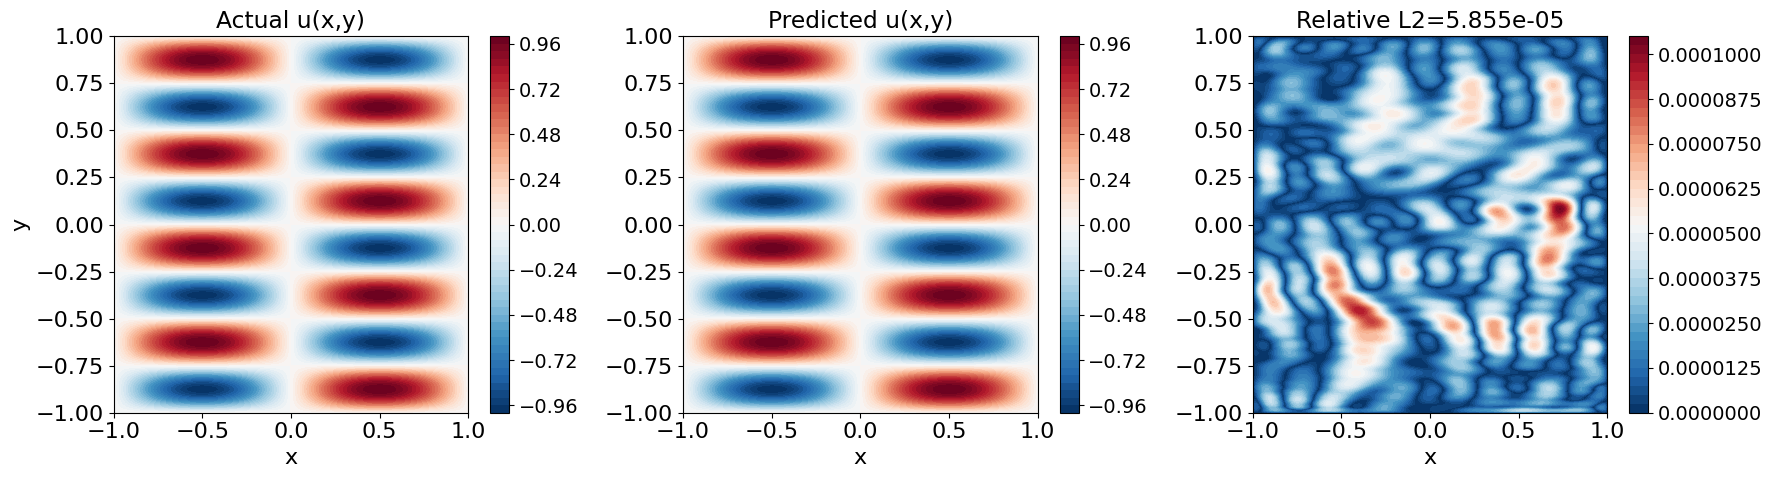

In [18]:
u_fx                = u_model(params)
#prediction 
xy, u_real          = X_exact[:, :2], X_exact[:, 2:]
u_pred              = vmap(u_fx, (0))(xy)[:,None]
u_pred              =jax.device_get(u_pred)
a=relative_error2(u_pred.flatten(),u_real.flatten())
print(f'Final RL2 error: {a:.3e}')
U_pred=np.reshape(u_pred,(nx,ny))
Error=np.abs(u-U_pred)
Exact=np.array([u,U_pred,Error])  
plot3D_mat(X,Y,Exact,f_names=['Actual u(x,y)','Predicted u(x,y)',f'Relative L2={a:.3e}'],cmap='RdBu_r',window=5,font_size=14)
plt.tight_layout()


100%|██████████| 412/412 [00:00<00:00, 2079.54it/s]


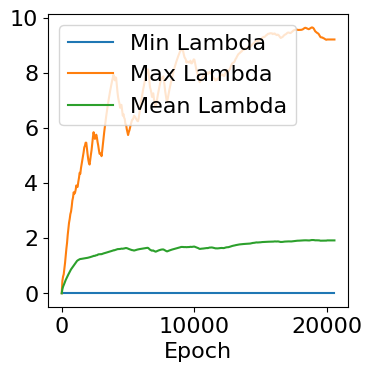

In [19]:
lambda_res_min=[]
lambda_res_max=[]
lambda_res_mean=[]
mpl.rcParams['font.size'] = 16
for i in tqdm(range(len(log_lambdas))):
    lambda_res_min.append(lamE*np.min(log_lambdas[i]['Res']))
    lambda_res_max.append(lamE*np.max(log_lambdas[i]['Res']))
    lambda_res_mean.append(lamE*np.mean(log_lambdas[i]['Res']))
fig, axs = plt.subplots(1,1,figsize=(4,4))
axs.plot(np.arange(len(lambda_res_max))*50, (lambda_res_min), label = f'Min Lambda')
axs.plot(np.arange(len(lambda_res_max))*50, (lambda_res_max), label = f'Max Lambda')
axs.plot(np.arange(len(lambda_res_mean))*50,(lambda_res_mean), label = f'Mean Lambda')
axs.set_xlabel('Epoch')
axs.legend(loc='upper left')
plt.tight_layout()
plt.show()


# References

Anagnostopoulos, S. J., Toscano, J. D., Stergiopulos, N., & Karniadakis, G. E. (2024). Residual-based attention in physics-informed neural networks. Computer Methods in Applied Mechanics and Engineering, 421, 116805.

Link: https://www.sciencedirect.com/science/article/pii/S0045782524000616?dgcid=coauthor